Load Data

In [0]:
!pip install --upgrade scikit-image progressbar2

Requirement already up-to-date: scikit-image in /usr/local/lib/python3.6/dist-packages (0.14.2)
Requirement already up-to-date: progressbar2 in /usr/local/lib/python3.6/dist-packages (3.39.3)


In [0]:
from skimage.util import view_as_blocks, view_as_windows, montage
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import randint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, transforms
import time
import os
import copy
import torch
from torch import tensor 
from torch.autograd import Variable
from torch import randn, matmul
import matplotlib.pyplot as plt
from scipy.misc import imresize, bytescale
from progressbar import progressbar
from google.colab import files

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
import tflearn.datasets.oxflower17 as oxflower17
X, Y = oxflower17.load_data(resize_pics=(227, 227), one_hot=True)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
X.shape, Y.shape

((1360, 227, 227, 3), (1360, 17))

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float).transpose(3,1),torch.tensor(Y, dtype=torch.float))
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [0]:
def NC(a):
  
#   return torch.matmul(X,torch.diag(torch.div(1, X.pow(2).sum(dim=0).sqrt())))

  return torch.mm(a, torch.diag(1./(torch.sqrt(torch.sum(a**2, 0))+1e-6)))

In [0]:
def whiten(X):
    '''Function to ZCA whiten image matrix.'''
    U,S,V = torch.svd(torch.mm(X, torch.t(X)))
    epsilon = 1e-5
    ZCAMatrix = torch.mm(U, torch.mm(torch.diag(1.0/torch.sqrt(S + epsilon)),
                                                torch.t(U)))
    return torch.mm(ZCAMatrix, X)

In [0]:
def toImg(arr):
  return ((arr - arr.min()) * (1/(arr.max() - arr.min()) * 255)).astype('uint8')

In [0]:
def get_batch(X, patchshape, batch_size=200, step=11):
  
  ix = randint(0,X.shape[1]-patchshape[0])
  iy = randint(0,X.shape[2]-patchshape[1])
  iz = randint(0,X.shape[3]-patchshape[2]) if patchshape[2] != X.shape[3] else 0
  
  iax = ix + patchshape[0]
  iay = iy + patchshape[1]
  iaz = iz + patchshape[2]

  B = X[randint(0,X.shape[0], size=batch_size),ix:iax,iy:iay,iz:iaz].contiguous().view(batch_size, patchshape[0]*patchshape[1]*patchshape[2])

  B = B.t()
  
  B = whiten(B- torch.mean(B, 0))
  
  return B
                 

In [0]:
def X3(X, filter_size, filter_depth, num_filters, iters=500):
  
  W = Variable(randn(filter_size*filter_size*filter_depth,num_filters))

  for i in progressbar(range(iters)):
    
    lX = get_batch(X, (filter_size, filter_size, filter_depth))
    
    W = NC(W)
    
    a = torch.matmul(W.t(), lX)
    
    a = NC(a)
    
    a = 0.5*a.pow(3)
    
    W += matmul((lX - matmul(W,a)),a.t())
    
  
  return W.transpose(1,0).view(num_filters, filter_size, filter_size, filter_depth)

In [0]:
class X3Net(nn.Module):

    def __init__(self):
        super(X3Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Linear(2048, 17),
        )

    def part1(self, x):
        x = self.conv1(x)
        return x
        
    def part2(self, x):
        x = self.part1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        return x
        
    def part3(self, x):
        x = self.part2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        return x
        
    def part4(self, x):
        x = self.part3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        return x
        
    def part5(self, x):
        x = self.part4(x)
        x = self.relu4(x)
        x = self.conv5(x)
        return x
        
    def forward(self, x):
        x = self.part5(x)
        x = self.relu5(x)
        x = self.pool5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:

Xp = torch.tensor(X, dtype=torch.float)

In [0]:
Xp.shape

torch.Size([1360, 227, 227, 3])

In [0]:
W = X3(Xp,11,3,64)

100% (500 of 500) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


In [0]:
W.shape

torch.Size([64, 11, 11, 3])

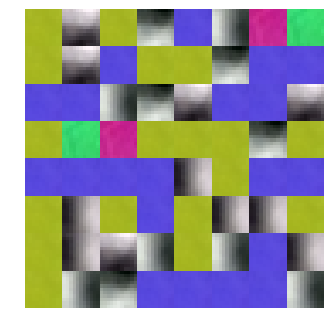

In [0]:
plt.grid(b=None)
plt.axis('off')
plt.imshow(montage(toImg(W.numpy()), multichannel=True))

In [0]:
net = X3Net().to(device)

In [0]:
net.conv1.weight.data = W.transpose(3,1).to(device)

In [0]:
Xp = net.part1(torch.tensor(X, dtype=torch.float).transpose(3,1).to(device)).cpu().detach().transpose(1,3)

In [0]:
Xp.shape

In [0]:
W = X3(Xp,5,64,192)

In [0]:
W.shape

In [0]:
plt.imshow(montage(toImg(W[15].transpose(2,0).cpu().numpy())))

In [0]:
net.conv2.weight.data = W.transpose(3,1).to(device)

In [0]:
Xp = net.part2(torch.tensor(X, dtype=torch.float).transpose(3,1).to(device)).cpu().detach().transpose(1,3)

In [0]:
W = X3(Xp,3,192,384)

In [0]:
W.shape

In [0]:
net.conv3.weight.data = W.transpose(3,1).to(device)

In [0]:
Xp = net.part3(torch.tensor(X, dtype=torch.float).transpose(3,1).to(device)).cpu().detach().transpose(1,3)

In [0]:
W = X3(Xp,3,384,256)

In [0]:
net.conv4.weight.data = W.transpose(3,1).to(device)

In [0]:
Xp = net.part4(torch.tensor(X, dtype=torch.float).transpose(3,1).to(device)).cpu().detach().transpose(1,3)

In [0]:
W = X3(Xp,3,256,256)

In [0]:
net.conv5.weight.data = W.transpose(3,1).to(device)

In [0]:
net.conv1.weight.requires_grad = False
net.conv2.weight.requires_grad = False
net.conv3.weight.requires_grad = False
net.conv4.weight.requires_grad = False
net.conv5.weight.requires_grad = False

In [0]:
with open('x3net_flowers.model', 'wb') as f:
    torch.save(net, f)

In [0]:
#Load model from file
with open('x3net_flowers.model', 'rb') as f:
    net = torch.load(f).to(device)

In [0]:
net.conv4.weight.requires_grad = True
net.conv5.weight.requires_grad = True

In [0]:
for x in net.parameters():
    print(x.shape)
    print(x.dtype)
    print(torch.isnan(x).nonzero())

torch.Size([64, 3, 11, 11])
torch.float32
tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)
torch.Size([64])
torch.float32
tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
torch.Size([192, 64, 5, 5])
torch.float32
tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)
torch.Size([192])
torch.float32
tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
torch.Size([384, 192, 3, 3])
torch.float32
tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)
torch.Size([384])
torch.float32
tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
torch.Size([256, 384, 3, 3])
torch.float32
tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)
torch.Size([256])
torch.float32
tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
torch.Size([256, 256, 3, 3])
torch.float32
tensor([], device='cuda:0', size=(0, 4), dtype=torch.int64)
torch.Size([256])
torch.float32
tensor([], device='cuda:0', size=(0, 1), dtype=torch.int64)
torch.Size([4096, 9216])
tor

In [0]:
print(net)

X3Net(
  (conv1): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (relu1): ReLU(inplace)
  (pool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU(inplace)
  (pool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU(inplace)
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU(inplace)
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu5): ReLU(inplace)
  (pool5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=4096, out_features=2048

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, torch.argmax(labels,1))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels.data,1))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
optimizer_ft = optim.SGD(net.parameters(), lr=0.001, momentum=0.1)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.9)

In [0]:
net_45uf = train_model(net, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=50)

Epoch 0/49
----------
train Loss: 17.1330 Acc: 0.2853
val Loss: 1.5355 Acc: 0.4522

Epoch 1/49
----------
train Loss: 1.4924 Acc: 0.4890
val Loss: 1.0344 Acc: 0.6625

Epoch 2/49
----------
train Loss: 1.0658 Acc: 0.6419
val Loss: 0.8348 Acc: 0.6890

Epoch 3/49
----------
train Loss: 0.7763 Acc: 0.7566
val Loss: 0.6073 Acc: 0.8029

Epoch 4/49
----------
train Loss: 0.5118 Acc: 0.8404
val Loss: 0.2828 Acc: 0.9243

Epoch 5/49
----------
train Loss: 0.3206 Acc: 0.9074
val Loss: 0.2365 Acc: 0.9279

Epoch 6/49
----------
train Loss: 0.1849 Acc: 0.9551
val Loss: 0.0851 Acc: 0.9860

Epoch 7/49
----------
train Loss: 0.0931 Acc: 0.9794
val Loss: 0.0525 Acc: 0.9926

Epoch 8/49
----------
train Loss: 0.0447 Acc: 0.9963
val Loss: 0.0228 Acc: 0.9993

Epoch 9/49
----------
train Loss: 0.0321 Acc: 0.9963
val Loss: 0.0171 Acc: 1.0000

Epoch 10/49
----------
train Loss: 0.0170 Acc: 1.0000
val Loss: 0.0115 Acc: 1.0000

Epoch 11/49
----------
train Loss: 0.0120 Acc: 1.0000
val Loss: 0.0094 Acc: 1.0000

E